In [30]:
import collections
import os
import sys
import logging
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard
from batch_generator import KerasBatchGenerator
from optparse import OptionParser
#from loader import load_data

In [31]:
os.getcwd()

'/Users/vikrant/jupyternotebooks/rnn500k'

In [33]:
logger = logging.getLogger('RNN-DeepLog')
def read_words(filename):
    #This should be optimize for loading stream based
    return pd.read_csv(filename).EventId


def build_vocab(filename):
    # Check later if there is a better way to transform it to id
    data = read_words(filename)
    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    print('word_to_id',type(word_to_id), 'len:',len(word_to_id), 'values:', word_to_id.values, 'keys', word_to_id.keys)
    return word_to_id


def file_to_word_ids(filename, word_to_id):
    data = read_words(filename)
    #print('data',  type(data), 'len:',len(data), 'sample:', data)
    return [word_to_id[word] for word in data if word in word_to_id]

def load_data(data_path):
    logger.info('Loading data {}'.format(data_path))

    train_file="{}-train.csv".format(data_path)
    test_file="{}-test.csv".format(data_path)
    valid_file="{}-valid.csv".format(data_path)

    train_path = os.path.join(data_path, train_file)
    test_path = os.path.join(data_path, test_file)
    valid_path = os.path.join(data_path, valid_file)
    word_to_id = build_vocab(train_path)
    train_data = file_to_word_ids(train_path, word_to_id)
    test_data = file_to_word_ids(test_path, word_to_id)
    valid_data = file_to_word_ids(test_path, word_to_id)

    vocabulary = len(word_to_id)
    reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))
    print(len(train_data), len( test_data), len(valid_data),len(reversed_dictionary))# len(vocabulary), )
    return train_data, test_data, valid_data, vocabulary, reversed_dictionary

In [34]:
data_path =  '/Users/vikrant/jupyternotebooks/rnn500k/Spell_result/logfileSorted2M'
print(data_path)

/Users/vikrant/jupyternotebooks/rnn500k/Spell_result/logfileSorted2M


In [35]:
train_data, test_data, valid_data, vocabulary, reversed_dictionary = load_data(data_path)

word_to_id <class 'dict'> len: 891 values: <built-in method values of dict object at 0x129258ee8> keys <built-in method keys of dict object at 0x129258ee8>
1599784 199923 199923 891


In [36]:
logger.info('Data loaded Vocabulary [{}]'.format(vocabulary))

In [37]:
num_steps = 30
batch_size = 10
num_epochs = 20

In [38]:
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocabulary,
                                                   skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocabulary,
                                                   skip_step=num_steps)

In [27]:
#Path to CSV Files
path = "/Users/vikrant/jupyternotebooks/rnn500K"
os.chdir(path)
os.getcwd()

'/Users/vikrant/jupyternotebooks/rnn500k'

In [39]:
from time import time
hidden_size = 100
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))
tensorboard = TensorBoard(log_dir="logs2/{}".format(time(), histogram_freq = 1,
        embeddings_freq = 1, write_graph=True, write_images=True))
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
checkpointer = ModelCheckpoint(filepath='/Users/vikrant/jupyternotebooks/rnn500K/Spell_result' + '/model-{epoch:02d}.hdf5', verbose=1)
history = model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
                    validation_data=valid_data_generator.generate(),
                    validation_steps=len(valid_data)//(batch_size*num_steps), callbacks=[checkpointer, tensorboard])
print('1')
model.save('/Users/vikrant/jupyternotebooks/rnn1/Spell_result/'+ "final_model.hdf5")
print('2')

Epoch 1/20
5332/5332 [==============================] - 837s 157ms/step - loss: 1.3145 - categorical_accuracy: 0.6214 - val_loss: 1.1194 - val_categorical_accuracy: 0.6824
Epoch 2/20
5332/5332 [==============================] - 806s 151ms/step - loss: 1.1200 - categorical_accuracy: 0.6845 - val_loss: 1.0366 - val_categorical_accuracy: 0.6929
Epoch 3/20
5332/5332 [==============================] - 831s 156ms/step - loss: 1.0876 - categorical_accuracy: 0.6904 - val_loss: 1.0175 - val_categorical_accuracy: 0.6977
Epoch 4/20
5332/5332 [==============================] - 840s 158ms/step - loss: 1.0688 - categorical_accuracy: 0.6933 - val_loss: 1.0070 - val_categorical_accuracy: 0.6988
Epoch 5/20
5332/5332 [==============================] - 879s 165ms/step - loss: 1.0565 - categorical_accuracy: 0.6948 - val_loss: 0.9991 - val_categorical_accuracy: 0.7005
Epoch 6/20
5332/5332 [==============================] - 1039s 195ms/step - loss: 1.0485 - categorical_accuracy: 0.6960 - val_loss: 0.9934 - 

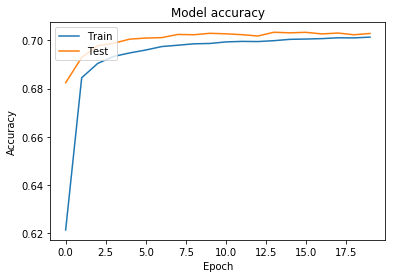

In [40]:

import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



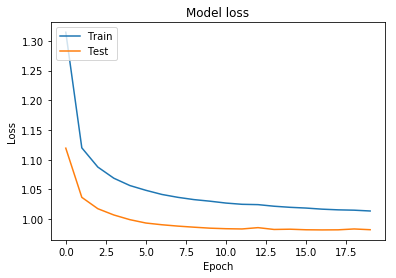

In [41]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
from log_translator import LogTranslator
from keras.models import load_model

model = load_model('/Users/vikrant/jupyternotebooks/rnn1/Spell_result/' + "final_model.hdf5")

translator = LogTranslator(data_path)
dummy_iters = 100
example_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,
                                                 skip_step=1)
print("Training data:")
for i in range(dummy_iters):
    dummy = next(example_training_generator.generate())
num_predict = 100
true_print_out = "Actual words:\n"
pred_print_out = "Predicted words:\n"
for i in range(num_predict):
    data = next(example_training_generator.generate())
    print('data', data[0])
    prediction = model.predict(data[0])
    print('prediction:', prediction.argmax)
    predict_word = np.argmax(prediction[:, num_steps-1, :])
    print('predict_word:', predict_word)
    true_print_out += translator.translate(reversed_dictionary[train_data[num_steps + dummy_iters + i]]) + "\n"
    print('[num_steps + dummy_iters + i]:', num_steps + dummy_iters + i)
    print('train_data[num_steps + dummy_iters + i]:',train_data[num_steps + dummy_iters + i])
    print('reversed_dictionary[train_data[num_steps + dummy_iters + i]]:', reversed_dictionary[train_data[num_steps + dummy_iters + i]])
    pred_print_out += translator.translate(reversed_dictionary[predict_word]) + "\n"
    print('reversed_dictionary[predict_word]', reversed_dictionary[predict_word])
print(true_print_out)
print(pred_print_out)
# test data set
dummy_iters = 100
example_test_generator = KerasBatchGenerator(test_data, num_steps, 1, vocabulary, skip_step=1)
print("Test data:")
for i in range(dummy_iters):
    dummy = next(example_test_generator.generate())
num_predict = 10
true_print_out = "Actual words:\n"
pred_print_out = "Predicted words:\n"
for i in range(num_predict):
    data = next(example_test_generator.generate())
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, num_steps - 1, :])
    true_print_out += translator.translate(reversed_dictionary[test_data[num_steps + dummy_iters + i]]) + "\n"
    pred_print_out += translator.translate(reversed_dictionary[predict_word]) + "\n"
print(true_print_out)
print(pred_print_out)

Training data:
Actual words:
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * login * * refused by host
STATE * login * * refused by host
STATE * login * * refused by host
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packet loss 0% RTA * ms
STATE * OK - Packe

In [45]:
 #train_data, test_data, valid_data, vocabulary, reversed_dictionary = load_data(data_path)
from log_translator import LogTranslator
from keras.models import load_model

model = load_model('C:\\Users\\sarim\\Desktop\\rnn1\\' + "final_model.hdf5")

translator = LogTranslator(data_path)
dummy_iters = 10
example_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,
                                                 skip_step=1)
print("Training data:")
for i in range(dummy_iters):
    dummy = next(example_training_generator.generate())
print('dummy', dummy)
num_predict = 10
true_print_out = "Actual words:\n"
pred_print_out = "Predicted words:\n"
for i in range(num_predict):
    data = next(example_training_generator.generate())
    print('data', data[0])
    prediction = model.predict(data[0])
    print('prediction:', prediction.argmax)
    predict_word = np.argmax(prediction[:, num_steps-1, :])
    print('predict_word:', predict_word)
    true_print_out += translator.translate(reversed_dictionary[train_data[num_steps + dummy_iters + i]]) + "\n"
    print('[num_steps + dummy_iters + i]:', num_steps + dummy_iters + i)
    print('train_data[num_steps + dummy_iters + i]:',train_data[num_steps + dummy_iters + i])
    print('reversed_dictionary[train_data[num_steps + dummy_iters + i]]:', reversed_dictionary[train_data[num_steps + dummy_iters + i]])
    pred_print_out += translator.translate(reversed_dictionary[predict_word]) + "\n"
    print('reversed_dictionary[predict_word]', reversed_dictionary[predict_word])
print(true_print_out, '::::::::', pred_print_out)
#rint(pred_print_out)
# test data set
dummy_iters = 100
example_test_generator = KerasBatchGenerator(test_data, num_steps, 1, vocabulary, skip_step=1)
print("Test data:")
for i in range(dummy_iters):
    dummy = next(example_test_generator.generate())
num_predict = 10
true_print_out = "Actual words:\n"
pred_print_out = "Predicted words:\n"
for i in range(num_predict):
    data = next(example_test_generator.generate())
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, num_steps - 1, :])
    true_print_out += translator.translate(reversed_dictionary[test_data[num_steps + dummy_iters + i]]) + "\n"
    pred_print_out += translator.translate(reversed_dictionary[predict_word]) + "\n"
print(true_print_out)
print(pred_print_out)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [51]:
import imp
imp.find_module("matplotlib")

(None,
 '/Users/vikrant/anaconda3/lib/python3.6/site-packages/matplotlib',
 ('', '', 5))